# Análisis de Vecino mas Cercano

Los SIG nos permiten analizar las relaciones espaciales entre elementos. Uno de estos análisis es identificar que objetos espaciales estan mas cerca uno de otro. En este tutorial vamos a replicar esta herramienta utilizando Python

## Objetivos

* El objetivo es identificar la comisaria mas cercana a cada una de las instituciones educativas (colegios) en la provincia de Ica.

## Obtener los datos

Para este tutorial descargamos los conjuntos de datos de las siguientes fuentes:

* Comisarias: [Directorios de comisarias](https://www.mininter.gob.pe/ubica-tu-comisaria) del Ministerio del Interio del Perú
* Instituciones educativas: [Estadisticas de la calidad educativa](https://escale.minedu.gob.pe/padron-de-iiee) del Ministerio de Educación del Perú

## Procedimiento

### 1. Preparación de los datos

Importar los modulos a utilizar

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.ops import nearest_points
from shapely.geometry import LineString, Point
print('Realizado')

Realizado


Leer los conjuntos de datos que utilizaremos. Las comisarias se encuentran en formato Shapefile y las instituciones educativas en valores separador por coma (csv).

In [2]:
# Lectura de comisarias
gdfComisarias = gpd.read_file('data/comisarias_peru.shp')

# Lectura de colegios
dfColegios = pd.read_csv('data/Padron_web.csv', encoding='UTF-8', sep=';', low_memory=False)

print('Realizado')

Realizado


In [3]:
# Visualizar comisarias
gdfComisarias.head(3)

,id,nombre,departamen,provincia,distrito,ubigeo,lon,lat,geometry
0,32,COMISARIA INDIANA,LORETO,MAYNAS,INDIANA,160104,-73.042052,-3.499631,POINT (-73.04205 -3.49963)
1,33,COMISARIA RURAL SINCHICUY,LORETO,MAYNAS,INDIANA,160104,-73.139910,-3.588879,POINT (-73.13991 -3.58888)
2,34,COMISARIA FRANCISCO DE ORELLANA,LORETO,MAYNAS,LAS AMAZONAS,160105,-72.764743,-3.422353,POINT (-72.76474 -3.42235)


La capa de colegios contiene muchas columnas, vamos a listar los nombres para visualizar las columnas que contienen las coordenadas.

In [4]:
# Listado de columnas de colegios
dfColegios.columns.values

array(['COD_MOD', 'ANEXO', 'CODLOCAL', 'CEN_EDU', 'NIV_MOD', 'D_NIV_MOD',
       'D_FORMA', 'COD_CAR', 'D_COD_CAR', 'TIPSSEXO', 'D_TIPSSEXO',
       'GESTION', 'D_GESTION', 'GES_DEP', 'D_GES_DEP', 'DIRECTOR',
       'TELEFONO', 'EMAIL', 'PAGWEB', 'DIR_CEN', 'REFERENCIA',
       'LOCALIDAD', 'CODCP_INEI', 'CODCCPP', 'CEN_POB', 'AREA_CENSO',
       'DAREACENSO', 'CODGEO', 'D_DPTO', 'D_PROV', 'D_DIST', 'D_REGION',
       'CODOOII', 'D_DREUGEL', 'NLAT_IE', 'NLONG_IE', 'TIPOPROG',
       'D_TIPOPROG', 'COD_TUR', 'D_COD_TUR', 'ESTADO', 'D_ESTADO',
       'D_FTE_DATO', 'TALUM_HOM', 'TALUM_MUJ', 'TALUMNO', 'TDOCENTE',
       'TSECCION', 'FECHAREG', 'FECHA_ACT'], dtype=object)

In [5]:
# Visualizar coordenadas de colegios
dfColegios[['NLAT_IE', 'NLONG_IE']].head(3)

,NLAT_IE,NLONG_IE
0,-9.51885,-77.53191
1,-9.53067,-77.53196
2,-9.53110,-77.52270


Observamos que las coordenadas estan expresadas grados decimales utilizando el Sistema de Referencia geodésico WGS84

Utilizando la clase **[geopandas.GeoDataFrame](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html)** y el método **[geopandas.points_from_xy](https://geopandas.org/en/stable/docs/reference/api/geopandas.points_from_xy.html)** realizaremos la conversion de las instituciones educativas de DataFrame a GeoDataFrame.

In [6]:
# Crear arreglo de geometrias con points_from_xy
geometry = gpd.points_from_xy(x=dfColegios.NLONG_IE, y=dfColegios.NLAT_IE, crs="EPSG:4326")
type(geometry)

geopandas.array.GeometryArray

In [7]:
# Convertir DataFrame a GeoDataFrame
gdfColegios = gpd.GeoDataFrame(dfColegios, geometry=geometry)
type(gdfColegios)

geopandas.geodataframe.GeoDataFrame

In [8]:
# Visualizar GeoDataFrame
gdfColegios[['NLAT_IE', 'NLONG_IE', 'geometry']].head()

,NLAT_IE,NLONG_IE,geometry
0,-9.518850,-77.531910,POINT (-77.53191 -9.51885)
1,-9.530670,-77.531960,POINT (-77.53196 -9.53067)
2,-9.531100,-77.522700,POINT (-77.52270 -9.53110)
3,-9.516673,-77.531481,POINT (-77.53148 -9.51667)
4,-9.513940,-77.504026,POINT (-77.50403 -9.51394)


Filtrar datos en la provincia de **Ica**.

In [9]:
# Filtrar comisarias
gdfComisariasIca = gdfComisarias.loc[gdfComisarias.provincia=='ICA']
gdfComisariasIca.shape

(15, 9)

In [10]:
# Filtrar colegios
gdfColegiosIca = gdfColegios.loc[gdfColegios.D_PROV=='ICA']
gdfColegiosIca.shape

(1880, 51)

Transformar las capas a SRC Proyectado WGS84 Zona 18 Sur (**EPSG:32718**)

In [11]:
gdfComisariasIca = gdfComisariasIca.to_crs(epsg=32718)
gdfColegiosIca = gdfColegiosIca.to_crs(epsg=32718)
print('Realizado')

Realizado


In [12]:
# Verificar la geometria de las comisarias
gdfComisariasIca['geometry'].head(3)

1230    POINT (420968.872 8444929.856)
1231    POINT (420898.832 8444421.778)
1232    POINT (423270.684 8448107.866)
Name: geometry, dtype: geometry

In [13]:
# Verificar la geometria de los colegios
gdfColegiosIca['geometry'].head(3)

20230    POINT (419160.181 8446071.519)
20231    POINT (419153.412 8443919.343)
20232    POINT (420587.574 8441757.110)
Name: geometry, dtype: geometry

### 2. Análisis del Vecino mas cercano

Crear función para calcular el vecino mas cercano

In [14]:
def vecino_mas_cercano(gdf_base, gdf_vecino, id_vecino):
    '''Funcion que calcula el vecino mas cercano en un GeoDataFrame'''
    
    # Devolver la union de todas la geometrias
    vecino_geometrias = gdf_vecino['geometry'].unary_union
    
    # Encontrar el punto mas cercano
    geometrias_cercanas = nearest_points(gdf_base['geometry'],vecino_geometrias)
    
    # Obtener el identificador del vecino mas cercanos
    gdf_vecino_cercano = gdf_vecino.loc[gdf_vecino['geometry'] == geometrias_cercanas[1]]
    id_vecino_cercano = gdf_vecino_cercano[id_vecino].values[0]
    
    return id_vecino_cercano
print('Realizado')

Realizado


Ejecutar la función para calcular el vecino mas cercano

In [15]:
gdfColegiosIca['id_vecino'] = gdfColegiosIca.apply(vecino_mas_cercano, 
                                                   gdf_vecino=gdfComisariasIca,
                                                   id_vecino='id',
                                                   axis=1)
print('Realizado')

Realizado


Visualizar los resultados

In [16]:
gdfColegiosIca[['NLAT_IE', 'NLONG_IE', 'geometry', 'id_vecino']].head()

,NLAT_IE,NLONG_IE,geometry,id_vecino
20230,-14.054920,-75.748740,POINT (419160.181 8446071.519),1460
20231,-14.074378,-75.748866,POINT (419153.412 8443919.343),1461
20232,-14.093968,-75.735645,POINT (420587.574 8441757.110),1461
20233,-13.984630,-75.772310,POINT (416589.856 8453837.680),1473
20234,-14.066910,-75.723760,POINT (421861.416 8444753.801),1460


Y listo, hemos identificado cual es la comisaria mas cercana a cada Colegios. Ahora veamos como se visualiza en un mapa

### 3. Visualización

Vamos a trazar las líneas que unen a los colegios con las comisarias. Para esto, vamos a realizar un **[merge](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html)** para recuperar las geometrias de las comisarias al GeoDataFrame de colegios.

In [17]:
dfColToCom = gdfColegiosIca.merge(gdfComisariasIca[['id','geometry']], how='left', 
                                      left_on='id_vecino', right_on='id',
                                      suffixes=('_col', '_com')
                                     )
print('Realizado')

Realizado


In [18]:
dfColToCom[['geometry_col', 'geometry_com']].head()

,geometry_col,geometry_com
0,POINT (419160.181 8446071.519),POINT (420968.872 8444929.856)
1,POINT (419153.412 8443919.343),POINT (420898.832 8444421.778)
2,POINT (420587.574 8441757.110),POINT (420898.832 8444421.778)
3,POINT (416589.856 8453837.680),POINT (416590.497 8453696.292)
4,POINT (421861.416 8444753.801),POINT (420968.872 8444929.856)


In [19]:
type(dfColToCom)

pandas.core.frame.DataFrame

Un geodataframe no puede tener dos geometrías, es por eso que al unirlos el resultado devuelve un **DataFrame** y los campos de geometría se convierten en tipo Punto Shapely.

Ahora, vamos a crear una función que genere una geometría **Shapely LineString** a partir de los **puntos shapely**.

In [20]:
crear_linea = lambda p1, p2: LineString([p1, p2])
print('Realizado')

Realizado


Y Ahora crearemos una nueva capa de líneas que une los colegios con las comisarias

In [21]:
cols=['CODLOCAL','id_vecino','geometry_col','geometry_com']
dfColToCom['geometry'] = dfColToCom[cols].apply(lambda row: crear_linea(row['geometry_col']
                                                                        , row['geometry_com'])
                                                , axis=1)
print('Realizado')

Realizado


Y ahora vamos convertir este DataFrame en GeodataFrame tomando como geometría el campo `geometry`

In [22]:
# Convertir a GeoDataFrame
gdfColToCom = gpd.GeoDataFrame(dfColToCom, geometry=dfColToCom['geometry'])

# Calcular la distancia que es la longitud
gdfColToCom['distancia'] = gdfColToCom.length

# Ver el tipo
type(gdfColToCom)

geopandas.geodataframe.GeoDataFrame

In [23]:
gdfComisariasIca.bounds.min().astype(int)

minx     402142
miny    8413811
maxx     402142
maxy    8413811
dtype: int32

Y Ahora si! Grafiquemos.

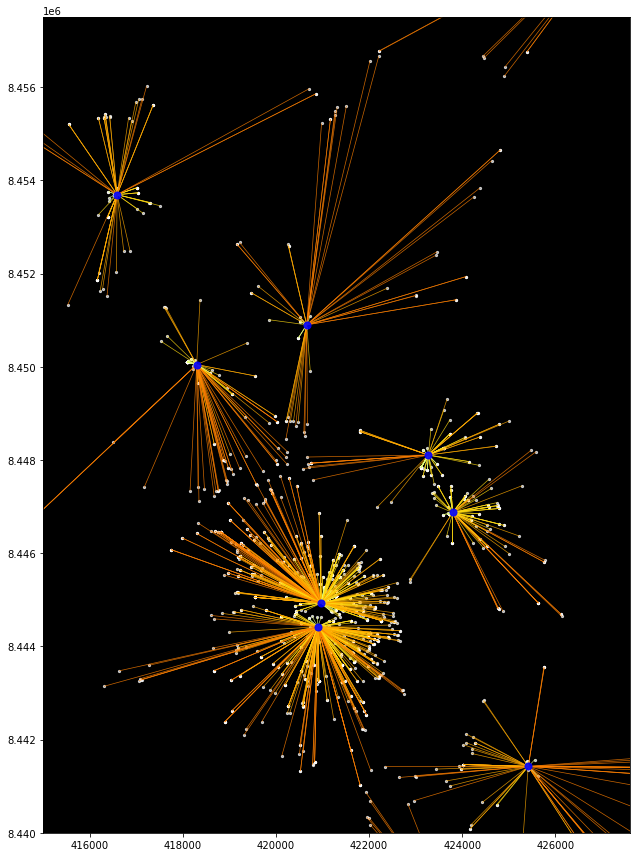

In [24]:
# Trazando las distancia, colegios y comisarias
ax = gdfColToCom.plot(column='distancia'
                      , cmap='Wistia'
                      , scheme='quantiles'
                      , figsize=(15, 15)
                      , k=4
                      , alpha=0.8
                      , lw=0.7
                     )

ax = gdfColegiosIca.plot(ax=ax
                         , color='white'
                         , markersize=5
                         , alpha=0.7
                        )

ax = gdfComisariasIca.plot(ax=ax
                           , markersize=50
                           , color='blue'
                           , alpha=0.9
                           , zorder=3)

# Haciendo zoom a una zona
ax.set_xlim([415000, 427591])
ax.set_ylim([8440000, 8457500])

# Color del fondo
ax.set_facecolor('black')

### Referencias

* Documentación [Geopandas](https://geopandas.org/en/stable/index.html)
* Documentación [Shapely](https://shapely.readthedocs.io/en/stable/manual.html)
* Curso [Automating GIS-processes (University of Helsinki)](https://autogis-site.readthedocs.io/en/latest/index.html)